### This notebook is used for auROC analysis for neural responses.
To do list:
- [ ] PSTH for individual neurons (-1 to 3s)
- [ ] Bin data with 500-100 ms (arbitrary) for individual neurons
- [ ] Calculate baseline (-5 to -1s before onset? Or just use 1 sec before onset?)
- [ ] Plot distribution of ∆F/F values of both baseline and stimulus onset
- [ ] Calculate ROC with criteria from min to max ∆F/F
- [ ] Calculate AUC of ROC (auROC)
- [ ] For loop for distribution to auROC for each Bin (list append)
- [ ] Stats on auROC trace stimulus onset vs baseline, only >3 bins continuous significant different will be counted as responsive neurons.
- [ ] Count neurons for % of neuron for activated, suppressed, neutral.

For cross correlation
https://currents.soest.hawaii.edu/ocn_data_analysis/_static/SEM_EDOF.html

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#plt.style.use('seaborn')
import seaborn as sns

import os
import glob

import datetime

import numpy as np
import pandas as pd
import math
from random import randrange
from random import randint

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# import sys
# sys.path.append("/Users/hunglo/Dropbox/AG_Johenning_Schmitz/Programming/python/")
# import os
# from figures import plotinscopixtraces


Bad key "text.kerning_factor" on line 4 in
/Users/hunglo/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import matplotlib.colors as colors
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [43]:
## Helper functions

## Def phensys converter for lick rate
def timestampconvert(x):
  stamp = datetime.timedelta(days = x)
  result = datetime.datetime(1899,12,30,0,0) + stamp
  # print(result.strftime('%Y-%m-%d %H:%M:%S.%f'))
  return result

def datetime_convert_phenosys(csv_path):
    df_pheno = pd.read_csv(csv_path)
    time_list = df_pheno['DateTime']
    result = []
    for x in time_list:
        timestampconvert(x)
        result.append(timestampconvert(x))
    new_time_stamps = []
    for i in result:
        new_time_stamps.append((i-min(result)).total_seconds())
    df_pheno = df_pheno.fillna(0)
    df_pheno['DateTime'] = new_time_stamps
    # df_pheno
    return df_pheno

## Function for getting L1 and L2 lick events
def lick_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from sensor L1, L2 and the timestamps of both channels. It will also do a quick plotting for the lick sensor data for raster plots and the density plot of overall lick events.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    L1_time = df[df['unitLabel']=='L1']['DateTime'].values
    L1_value = df[df['unitLabel']=='L1']['MsgValue1'].values

    L1_timestamps_new = []
    for idx,value in enumerate(L1_value):
        if len(value.split(','))>1:
            # print(value.split(','))
            for j in value.split(',')[1:]:
                # print(j.split('-')[0])
                individual_value = int(j.split('-')[0])*0.001 # convert ms to s
                # print(L1_time[idx]+individual_value)
                if idx == 0:
                    L1_timestamps_new.append(L1_time[idx]+individual_value)
                else:
                    L1_timestamps_new.append(L1_timestamps_new[-1]+individual_value)
        else:
            L1_timestamps_new.append(L1_time[idx])

    ## The same for L2
    L2_time = df[df['unitLabel']=='L2']['DateTime'].values
    L2_value = df[df['unitLabel']=='L2']['MsgValue1'].values

    L2_timestamps_new = []
    for idx,value in enumerate(L2_value):
        if len(value.split(','))>1:
            # print(value.split(','))
            for j in value.split(',')[1:]:
                # print(j.split('-')[0])
                individual_value = int(j.split('-')[0])*0.001
                # print(L1_time[idx]+individual_value)
                if idx == 0:
                    L2_timestamps_new.append(L2_time[idx]+individual_value)
                else:
                    L2_timestamps_new.append(L2_timestamps_new[-1]+individual_value)
        else:
            L2_timestamps_new.append(L2_time[idx])

    all_lick_events = sorted(L1_timestamps_new + L2_timestamps_new)

    print('File processed: '+csv_path.split('/')[-1])
    print('Is there any duplication?: '+ str(len(L1_timestamps_new) != len(set(L1_timestamps_new))))

    fig, [ax0,ax1] = plt.subplots(nrows=2,ncols=1,sharex=True,figsize=[8,4])
    ax0.eventplot([L1_timestamps_new,L2_timestamps_new,all_lick_events],lw=0.5,linelengths=0.8,color=['C0','C1','C3'])
    legend=ax0.legend(['L1','L2','All'],bbox_to_anchor=(0., 1.1, 1., 1.1), loc=3, ncol=3, mode="expand", 
                borderaxespad=0.,frameon=False,title='Lick events for L1 & L2 lick sensors: '+csv_path.split('/')[-1],fontsize=8)
    
    legend.get_title().set_fontsize('9')
    
    # sns.distplot(L1_timestamps_new, hist=False, rug=True, ax=ax1, color='C0',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    # sns.distplot(L2_timestamps_new, hist=False, rug=True, ax=ax1, color='C1',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    sns.distplot(all_lick_events, hist=False, rug=True, ax=ax1, color='C3',rug_kws={"height":0.2,"linewidth":0.5,"alpha":0.5})
    ax0.set_yticks([])
    ax1.set_yticks([])
    plt.xlabel('Second',fontsize=8)
    plt.xticks(fontsize=8);plt.yticks(fontsize=8)
    plt.xlim([0,1600])
    plt.tight_layout();plt.show()
    return L1_timestamps_new, L2_timestamps_new, all_lick_events



## Function for getting P1 and P1C lick events
def GPIO_event_calculate(csv_path):
    """
    This function will calcuate the lick sensor data from the phenosys csv files and return 3 lists of timestamps from GPIOs P1 and P1C and the timestamps of both channels.

    """
    df = datetime_convert_phenosys(csv_path)
    
    # Get L1 timestamps and MsgValue1
    P1_time = df[df['unitLabel']=='P1']['DateTime'].values
    P1C_time = df[df['unitLabel']=='P1C']['DateTime'].values
    
    P2_time = df[df['unitLabel']=='P2']['DateTime'].values
    P2A_time = df[df['unitLabel']=='P2A']['DateTime'].values

    # all_pump_events = P1_time + P1C_time + P2_time + P2A_time
    pump_all = np.concatenate([P1_time,P1C_time,P2_time,P2A_time],axis=0)
    pump_all = sorted(pump_all)
    pump_all = np.array(pump_all)

    # fig, ax0 = plt.subplots(nrows=1,ncols=1,sharex=True,figsize=[8,2])
    # ax0.eventplot([P1_time,P1C_time,P2_time,P2A_time],lw=0.5,linelengths=0.8,color=['C0','C1','C3','C4'])
    # legend=ax0.legend(['P1','P1C','P2','P2A'],bbox_to_anchor=(0., 1.1, 1., 1.1), loc=3, ncol=4, mode="expand", 
    #             borderaxespad=0.,frameon=False,title='GPIO events: '+csv_path.split('/')[-1],fontsize=8)
    
    # legend.get_title().set_fontsize('9')
    
    # ax0.set_yticks([])
    # plt.xlabel('Second',fontsize=8)
    # plt.xticks(fontsize=8);plt.yticks(fontsize=8)
    # plt.xlim([0,1600])
    # plt.tight_layout();plt.show()
    
    return P1_time, P1C_time, P2_time, P2A_time, pump_all

## Filter function for np array
def filter_mask_large(arr, j):
    return arr[arr < j]
def filter_mask_small(arr, k):
    return arr[arr > k]

## find nearst value in np array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


In [3]:
## Plotting setting
plt.rcParams["font.family"] = "Arial"
plt.rcParams.update({'font.size': 10})

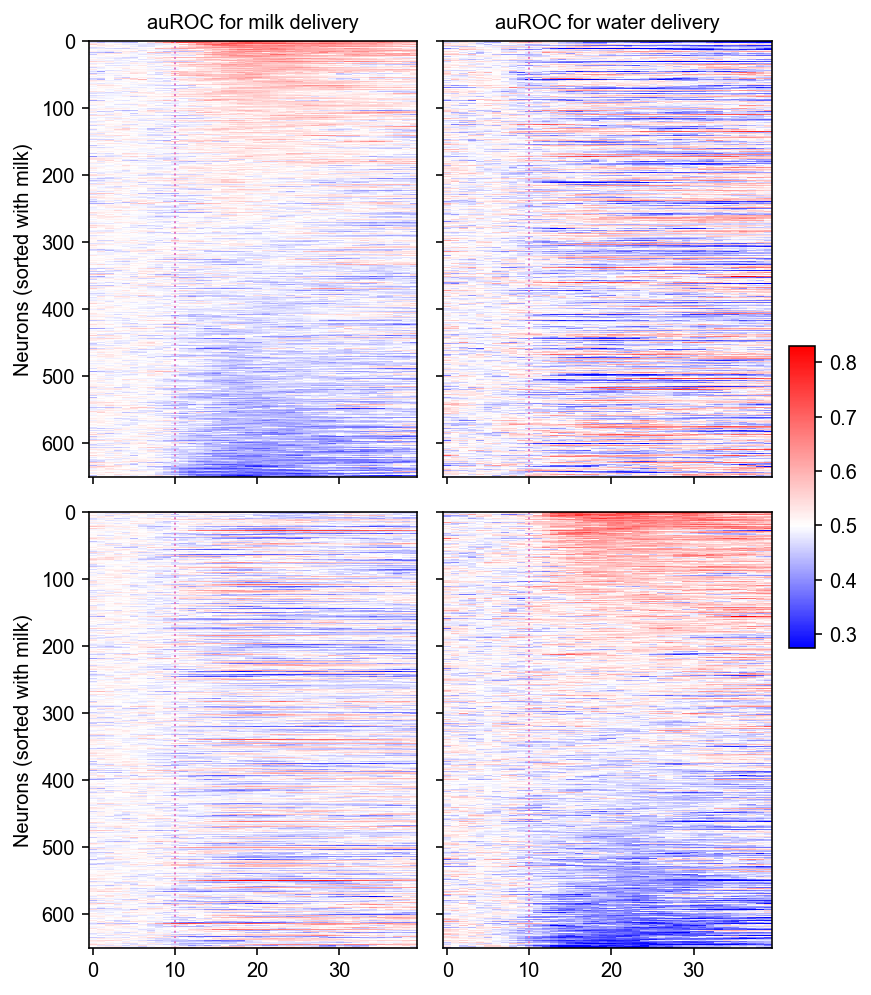

In [4]:
## Load auROC csv files to np array and then concatenate them together.
from numpy import genfromtxt

mouse_1_strawberry = genfromtxt('/Users/hunglo/Desktop/3rd_supervision/auROC/auROC_milk_BES0224200818.csv',delimiter=',')
mouse_2_strawberry = genfromtxt('/Users/hunglo/Desktop/3rd_supervision/auROC/auROC_milk_BES0225201007.csv',delimiter=',')
mouse_3_strawberry = genfromtxt('/Users/hunglo/Desktop/3rd_supervision/auROC/auROC_milk_BES0233200912.csv',delimiter=',')

mouse_1_water = genfromtxt('/Users/hunglo/Desktop/3rd_supervision/auROC/auROC_water_BES0224200818.csv',delimiter=',')
mouse_2_water = genfromtxt('/Users/hunglo/Desktop/3rd_supervision/auROC/auROC_water_BES0225201007.csv',delimiter=',')
mouse_3_water = genfromtxt('/Users/hunglo/Desktop/3rd_supervision/auROC/auROC_water_BES0233200912.csv',delimiter=',')

# Concatenate np arrays
mouse_all_strawberry = np.concatenate((mouse_1_strawberry, mouse_2_strawberry, mouse_3_strawberry), axis=1)
mouse_all_water = np.concatenate((mouse_1_water, mouse_2_water, mouse_3_water), axis=1)

# Sorting
isort_strawberry = np.argsort(-mouse_all_strawberry[10:30].mean(axis=0))
isort_water = np.argsort(-mouse_all_water[10:30].mean(axis=0))

# color map setting
elev_min = np.min(np.min(mouse_all_strawberry))
elev_max = np.min(np.max(mouse_all_strawberry))
mid_val=0.5

# initiate plotting

fig,[[ax0,ax1],[ax2,ax3]] = plt.subplots(ncols=2,nrows=2,figsize=[6,7],sharey=True,sharex=True)
im=ax0.imshow(mouse_all_strawberry.T[isort_strawberry], aspect='auto',cmap='bwr',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax0.set_title('auROC for milk delivery',fontsize=10)
ax0.vlines(x=10,ymin=-0.5,ymax=mouse_all_strawberry.shape[1]-0.5,ls=':',color='C6',lw=1)
ax0.set_ylabel('Neurons (sorted with milk)',fontsize=10)

ax1.imshow(mouse_all_water.T[isort_strawberry], aspect='auto',cmap='bwr',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax1.set_title('auROC for water delivery',fontsize=10)
ax1.vlines(x=10,ymin=-0.5,ymax=mouse_all_water.shape[1]-0.5,ls=':',color='C6',lw=1)

ax2.imshow(mouse_all_strawberry.T[isort_water], aspect='auto',cmap='bwr',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
# ax2.set_title('auROC for milk delivery',fontsize=10)
ax2.vlines(x=10,ymin=-0.5,ymax=mouse_all_strawberry.shape[1]-0.5,ls=':',color='C6',lw=1)
ax2.set_ylabel('Neurons (sorted with milk)',fontsize=10)

ax3.imshow(mouse_all_water.T[isort_water], aspect='auto',cmap='bwr',clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
# ax3.set_title('auROC for water delivery',fontsize=10)
ax3.vlines(x=10,ymin=-0.5,ymax=mouse_all_water.shape[1]-0.5,ls=':',color='C6',lw=1)


plt.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.35, 0.03, 0.3])
fig.colorbar(im, cax=cbar_ax,shrink=0.8)

plt.savefig('/Users/hunglo/Desktop/3rd_supervision/auROC/pooled_strawberry_auROC.pdf',dpi=600,transparent=True)

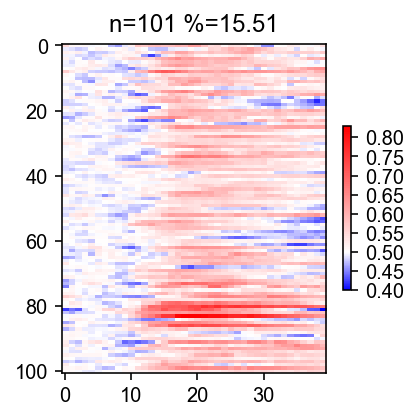

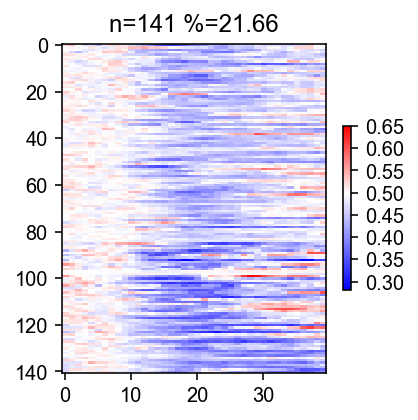

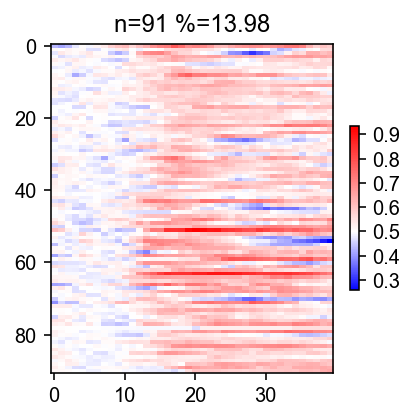

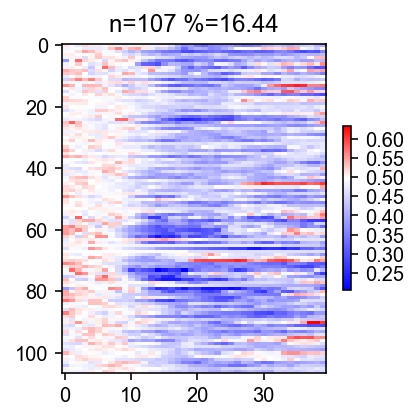

In [5]:
## Now perform thresholding for Milk +/N/- and Water +/N/- neurons.

# Milk +
data = pd.DataFrame(mouse_all_strawberry)

threshold_high = np.mean(data[0:10]) + np.std(data[0:10])*3.5
idx_positive = []
for cell in data.columns[:]:
    j_temp = []
    for j in range(10,25):
        if data[cell][j]>threshold_high[cell]:
            j_temp.append(j)
    if j_temp != []:
        for k,l in zip(j_temp[2:],j_temp[:-1]):
            if (k-l)==2:
                idx_positive.append(cell)
                break
elev_min=np.min(data[idx_positive].values.flatten())
elev_max=np.max(data[idx_positive].values.flatten())
mid_val=0.5
n = str(len(idx_positive))
perc = str(round(len(idx_positive)/data.shape[1]*100,2))
plt.figure(figsize=[3,3])
plt.imshow(data[idx_positive].T,cmap='bwr',aspect='auto',clim=[elev_min,elev_max],norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
plt.title('n='+n+' %='+perc)
plt.colorbar(shrink=0.5)
plt.tight_layout()
plt.show()

# Milk -
data = pd.DataFrame(mouse_all_strawberry)

threshold_low = np.mean(data[0:10]) - np.std(data[0:10])*3.5
idx_negative = []
for cell in data.columns[:]:
    j_temp = []
    for j in range(10,25):
        if data[cell][j]<threshold_low[cell]:
            j_temp.append(j)
    if j_temp != []:
        for k,l in zip(j_temp[2:],j_temp[:-1]):
            if (k-l)==2:
                idx_negative.append(cell)
                break
elev_min=np.min(data[idx_negative].values.flatten())
elev_max=np.max(data[idx_negative].values.flatten())
mid_val=0.5
n = str(len(idx_negative))
perc = str(round(len(idx_negative)/data.shape[1]*100,2))
plt.figure(figsize=[3,3])
plt.imshow(data[idx_negative].T,cmap='bwr',aspect='auto',clim=[elev_min,elev_max],norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
plt.title('n='+n+' %='+perc)
plt.colorbar(shrink=0.5)
plt.tight_layout()
plt.show()

# Water +
data = pd.DataFrame(mouse_all_water)

threshold_high = np.mean(data[0:10]) + np.std(data[0:10])*3.5
idx_positive_water = []
for cell in data.columns[:]:
    j_temp = []
    for j in range(10,25):
        if data[cell][j]>threshold_high[cell]:
            j_temp.append(j)
    if j_temp != []:
        for k,l in zip(j_temp[2:],j_temp[:-1]):
            if (k-l)==2:
                idx_positive_water.append(cell)
                break
elev_min=np.min(data[idx_positive_water].values.flatten())
elev_max=np.max(data[idx_positive_water].values.flatten())
mid_val=0.5
n = str(len(idx_positive_water))
perc = str(round(len(idx_positive_water)/data.shape[1]*100,2))
plt.figure(figsize=[3,3])
plt.imshow(data[idx_positive_water].T,cmap='bwr',aspect='auto',clim=[elev_min,elev_max],norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
plt.title('n='+n+' %='+perc)
plt.colorbar(shrink=0.5)
plt.tight_layout()
plt.show()

# Water -
data = pd.DataFrame(mouse_all_water)

threshold_low = np.mean(data[0:10]) - np.std(data[0:10])*3.5
idx_negative_water = []
for cell in data.columns[:]:
    j_temp = []
    for j in range(10,25):
        if data[cell][j]<threshold_low[cell]:
            j_temp.append(j)
    if j_temp != []:
        for k,l in zip(j_temp[2:],j_temp[:-1]):
            if (k-l)==2:
                idx_negative_water.append(cell)
                break
elev_min=np.min(data[idx_negative_water].values.flatten())
elev_max=np.max(data[idx_negative_water].values.flatten())
mid_val=0.5
n = str(len(idx_negative_water))
perc = str(round(len(idx_negative_water)/data.shape[1]*100,2))
plt.figure(figsize=[3,3])
plt.imshow(data[idx_negative_water].T,cmap='bwr',aspect='auto',clim=[elev_min,elev_max],norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
plt.title('n='+n+' %='+perc)
plt.colorbar(shrink=0.5)
plt.tight_layout()
plt.show()

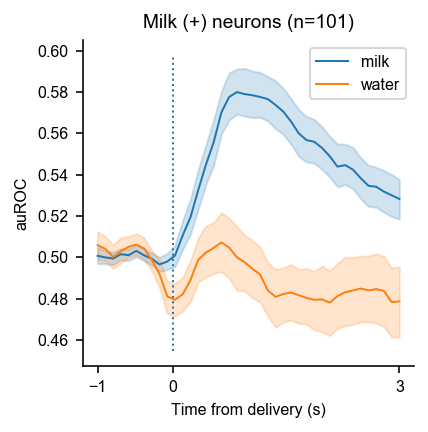

In [6]:
## Plot average line with CI (sns)

save_file_name = 'pooled_strawberry'

data = pd.DataFrame(mouse_all_strawberry)[idx_positive].copy()
data_w = pd.DataFrame(mouse_all_water)[idx_positive].copy()

data['timepoint']=np.linspace(-1,3,40)
data_melt = data.melt(id_vars='timepoint')
data_melt.columns = ['timepoint', 'cellname', 'auROC']

data_w['timepoint']=np.linspace(-1,3,40)
data_w_melt = data_w.melt(id_vars='timepoint')
data_w_melt.columns = ['timepoint', 'cellname', 'auROC']

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(figsize=[3,3])
sns.lineplot(data=data_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='milk')
sns.lineplot(data=data_w_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='water')

y_min, y_max = ax.get_ylim()
ax.vlines(x=0,ymin=y_min,ymax=y_max,ls=':',lw=1,color='C0')

# plt.legend(title='Drink')
sns.despine()
# ax.set_yticks(fontsize=8)
ax.set_ylabel('auROC')
ax.set_xticks([-1,0,3])
ax.set_xlabel('Time from delivery (s)')
ax.set_title('Milk (+) neurons (n='+str(len(idx_positive))+')')
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/auROC/'+save_file_name+'_auROC_milk_positive_neuron.pdf',dpi=300,transparent=True)

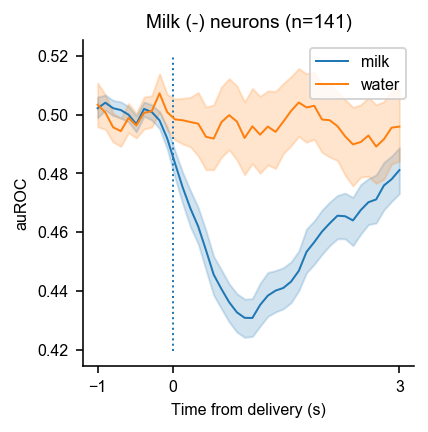

In [7]:
## Plot average line with CI (sns)

save_file_name = 'pooled_strawberry'

data = pd.DataFrame(mouse_all_strawberry)[idx_negative].copy()
data_w = pd.DataFrame(mouse_all_water)[idx_negative].copy()

data['timepoint']=np.linspace(-1,3,40)
data_melt = data.melt(id_vars='timepoint')
data_melt.columns = ['timepoint', 'cellname', 'auROC']
# data_melt

data_w['timepoint']=np.linspace(-1,3,40)
data_w_melt = data_w.melt(id_vars='timepoint')
data_w_melt.columns = ['timepoint', 'cellname', 'auROC']

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(figsize=[3,3])
sns.lineplot(data=data_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='milk')
sns.lineplot(data=data_w_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='water')

y_min, y_max = ax.get_ylim()
ax.vlines(x=0,ymin=y_min,ymax=y_max,ls=':',lw=1,color='C0')

# plt.legend(title='Drink')
sns.despine()
# ax.set_yticks(fontsize=8)
ax.set_ylabel('auROC')
ax.set_xticks([-1,0,3])
ax.set_xlabel('Time from delivery (s)')
ax.set_title('Milk (-) neurons (n='+str(len(idx_negative))+')')
plt.tight_layout()

plt.savefig('/Users/hunglo/Desktop/3rd_supervision/auROC/'+save_file_name+'_auROC_milk_negative_neuron.pdf',dpi=300,transparent=True)

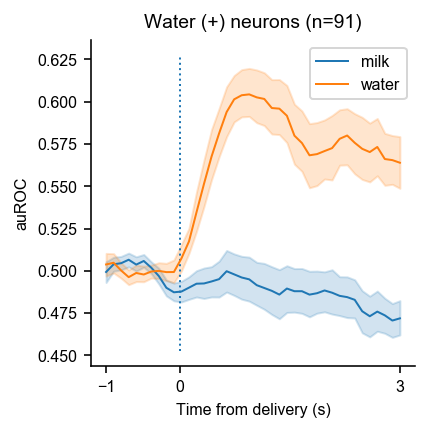

In [8]:
## Now for water positive cells
## Plot average line with CI (sns)

save_file_name = 'pooled_strawberry'

data = pd.DataFrame(mouse_all_strawberry)[idx_positive_water].copy()
data_w = pd.DataFrame(mouse_all_water)[idx_positive_water].copy()

data['timepoint']=np.linspace(-1,3,40)
data_melt = data.melt(id_vars='timepoint')
data_melt.columns = ['timepoint', 'cellname', 'auROC']
# data_melt

data_w['timepoint']=np.linspace(-1,3,40)
data_w_melt = data_w.melt(id_vars='timepoint')
data_w_melt.columns = ['timepoint', 'cellname', 'auROC']

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(figsize=[3,3])
sns.lineplot(data=data_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='milk')
sns.lineplot(data=data_w_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='water')

y_min, y_max = ax.get_ylim()
ax.vlines(x=0,ymin=y_min,ymax=y_max,ls=':',lw=1,color='C0')
# plt.legend(frameon=False)
sns.despine()
# ax.set_yticks(fontsize=8)
ax.set_ylabel('auROC')
ax.set_xticks([-1,0,3])
ax.set_xlabel('Time from delivery (s)')
ax.set_title('Water (+) neurons (n='+str(len(idx_positive_water))+')')
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/auROC/'+save_file_name+'_auROC_water_positive_neuron.pdf',dpi=300,transparent=True)

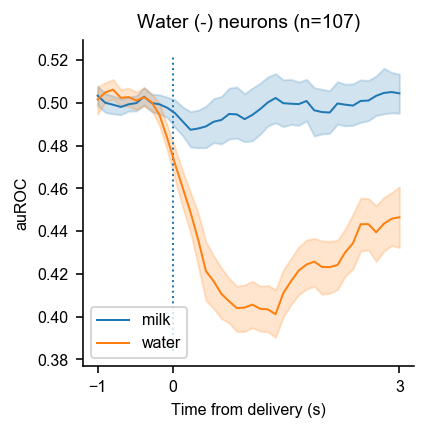

In [9]:
## Plotting for water negative neurons
## Plot average line with CI (sns)

save_file_name = 'pooled_strawberry'

data = pd.DataFrame(mouse_all_strawberry)[idx_negative_water].copy()
data_w = pd.DataFrame(mouse_all_water)[idx_negative_water].copy()

data['timepoint']=np.linspace(-1,3,40)
data_melt = data.melt(id_vars='timepoint')
data_melt.columns = ['timepoint', 'cellname', 'auROC']
# data_melt

data_w['timepoint']=np.linspace(-1,3,40)
data_w_melt = data_w.melt(id_vars='timepoint')
data_w_melt.columns = ['timepoint', 'cellname', 'auROC']

plt.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(figsize=[3,3])
sns.lineplot(data=data_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='milk')
sns.lineplot(data=data_w_melt,x='timepoint',y='auROC',ax=ax,lw=1,label='water')

y_min, y_max = ax.get_ylim()
ax.vlines(x=0,ymin=y_min,ymax=y_max,ls=':',lw=1,color='C0')
# plt.legend(frameon=False)
sns.despine()
# ax.set_yticks(fontsize=8)
ax.set_ylabel('auROC')
ax.set_xticks([-1,0,3])
ax.set_xlabel('Time from delivery (s)')
ax.set_title('Water (-) neurons (n='+str(len(idx_negative_water))+')')
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/auROC/'+save_file_name+'_auROC_water_negative_neuron.pdf',dpi=300,transparent=True)

In [10]:
import numpy as np
def overlap(a, b):
    # return the indices in a that overlap with b, also returns 
    # the corresponding index in b only works if both a and b are unique! 
    # This is not very efficient but it works
    bool_a = np.in1d(a,b)
    ind_a = np.arange(len(a))
    ind_a = ind_a[bool_a]

    ind_b = np.array([np.argwhere(b == a[x]) for x in ind_a]).flatten()
    return ind_a,ind_b



In [11]:
## Find overlapping of neurons in each catagories
# convert list to np array
idx_positive = np.array(idx_positive)
idx_positive_water = np.array(idx_positive_water)
idx_negative = np.array(idx_negative)
idx_negative_water = np.array(idx_negative_water)

# Milk + to water +
ind_Mp_Wp,_ = overlap(idx_positive,idx_positive_water)
print(len(ind_Mp_Wp))

# Milk + to water -
ind_Mp_Wn,_ = overlap(idx_positive,idx_negative_water)
print(len(ind_Mp_Wn))

# Milk - to water +
ind_Mn_Wp,_ = overlap(idx_negative,idx_positive_water)
print(len(ind_Mn_Wp))

# Milk - to water -
ind_Mn_Wn,_ = overlap(idx_negative,idx_negative_water)
print(len(ind_Mn_Wn))

# Milk + to water N 
# = Milk + total (101) - Milk(+) -> Water(+/-)
print(len(idx_positive) - len(ind_Mp_Wp) - len(ind_Mp_Wn))

# Milk - to water N
# = Milk - total (141) - Milk(-) -> Water(+/-)
print(len(idx_negative) - len(ind_Mn_Wp) - len(ind_Mn_Wn))

# Calculate Milk N to water + by find how many water + left after subtracting milk +/-
print(len(idx_positive_water) - len(ind_Mp_Wp) - len(ind_Mn_Wp))

# Calculate Milk N to water - by find how many water - left after subtracting milk +/-
print(len(idx_negative_water) - len(ind_Mp_Wn) - len(ind_Mn_Wn))

# Calculate Milk N to water N by total Milk N - above 2 numbers
# 651 is total neurons number, Milk N is 651- Milk + and Milk -

print(651-len(idx_positive)-len(idx_negative)-(len(idx_positive_water) - len(ind_Mp_Wp) - len(ind_Mn_Wp))-(len(idx_negative_water) - len(ind_Mp_Wn) - len(ind_Mn_Wn)))

13
17
20
25
71
96
58
65
286


## Load Ca2+ ∆F/F data here to illustrate how the Milk (+) neurons response to binge eating.

In [129]:
## Load corresponding ∆F/F files.

mouse_1_dff_path = '/Users/hunglo/Desktop/3rd_supervision/DFF_processed/BES0224200818_bingebout_1.csv'
mouse_1_dff = pd.read_csv(mouse_1_dff_path,index_col=0)
mouse_1_dff

mouse_2_dff_path = '/Users/hunglo/Desktop/3rd_supervision/DFF_processed/BES0225201007_bingebout_1.csv'
mouse_2_dff = pd.read_csv(mouse_2_dff_path,index_col=0)
mouse_2_dff

mouse_3_dff_path = '/Users/hunglo/Desktop/3rd_supervision/DFF_processed/BES0233200912_bingebout_1.csv'
mouse_3_dff = pd.read_csv(mouse_3_dff_path,index_col=0)
mouse_3_dff

## Normalized its own max,min to 1,0
mouse_1_dff_norm = (mouse_1_dff-mouse_1_dff.min())/(mouse_1_dff.max()-mouse_1_dff.min())
mouse_2_dff_norm = (mouse_2_dff-mouse_2_dff.min())/(mouse_2_dff.max()-mouse_2_dff.min())
mouse_3_dff_norm = (mouse_3_dff-mouse_3_dff.min())/(mouse_3_dff.max()-mouse_3_dff.min())


In [139]:
# mouse_3_dff.shape[1]

total_cell_num = len(idx_positive)
used_cell_num = len(idx_positive_mouse_1)+len(idx_positive_mouse_2)
residual_cell_num = total_cell_num-used_cell_num



In [142]:
## split idx_positive to 3 parts for 3 mice.
idx_positive_mouse_1 = idx_positive[idx_positive<=mouse_1_dff.shape[1]]
idx_positive_mouse_2_temp = idx_positive[idx_positive>mouse_1_dff.shape[1]]
idx_positive_mouse_2 = idx_positive_mouse_2_temp[idx_positive_mouse_2_temp<(mouse_1_dff.shape[1]+mouse_2_dff.shape[1])]
idx_positive_mouse_2 = idx_positive_mouse_2-mouse_1_dff.shape[1]

idx_positive_mouse_3 = idx_positive[-residual_cell_num:] - mouse_1_dff.shape[1] - mouse_2_dff.shape[1]
idx_positive_mouse_3

array([ 26,  39,  50,  86,  97, 118, 120, 122, 123, 124])

In [143]:
## For the first 369 cells from idx_positive, extract those Milk (+) neurons and plot their responses upon binging.
cell_set_1 = mouse_1_dff_norm.columns[idx_positive_mouse_1]
cell_set_2 = mouse_2_dff_norm.columns[idx_positive_mouse_2]
cell_set_3 = mouse_3_dff_norm.columns[idx_positive_mouse_3]

In [100]:
# idx_positive_mouse_1 = idx_positive[idx_positive<=369]

In [99]:
# mouse_1_dff.index[0]+60
# mouse_1_dff.index[-1]-60


In [98]:

# mouse_1_dff_norm[cell_set]

# im=plt.imshow(mouse_1_dff_norm[cell_set].T,aspect='auto',vmax=1,vmin=0.3)#,clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max),cmap='bwr')
# plt.plot([1200,mouse_1_dff.shape[0]-1200],[-2,-2])
# plt.colorbar(im)
# sns.despine()

In [103]:
## Load Pump_all from all 3 GPIO_phenodata

# mouse 1
mouse_id = 'BES0224'

# Locate file folder
GPIO_folder = '/Users/hunglo/Desktop/GPIO_phenosys_log_file/'+mouse_id+'/processed/'
extension = 'csv'
os.chdir(GPIO_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
idx = 6
_, _, _, _, Pump_all_1 = GPIO_event_calculate(GPIO_folder+result[idx])

# mouse 2
mouse_id = 'BES0225'
# Locate file folder
GPIO_folder = '/Users/hunglo/Desktop/GPIO_phenosys_log_file/'+mouse_id+'/processed/'
extension = 'csv'
os.chdir(GPIO_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
idx = -2
_, _, _, _, Pump_all_2 = GPIO_event_calculate(GPIO_folder+result[idx])

# mouse 3
mouse_id = 'BES0233'
# Locate file folder
GPIO_folder = '/Users/hunglo/Desktop/GPIO_phenosys_log_file/'+mouse_id+'/processed/'
extension = 'csv'
os.chdir(GPIO_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
idx = 4
_, _, _, _, Pump_all_3 = GPIO_event_calculate(GPIO_folder+result[idx])

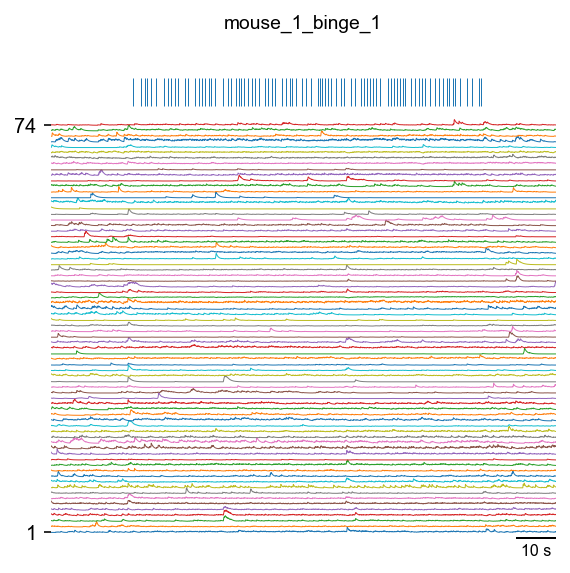

In [104]:
plt.figure(figsize=[4,4])
for order,cell in enumerate(cell_set_1):
    plt.plot(mouse_1_dff_norm[cell]+order+1,lw=0.5)
plt.eventplot(Pump_all_1,lineoffsets=order+7,linewidths=0.5,linelengths=5)
plt.plot([970,980],[0,0],color='k',lw=1)
plt.text(x=975,y=-1,s='10 s',ha='center',va='top')
plt.xlim([mouse_1_dff.index[0],mouse_1_dff.index[-1]])
plt.xlim([850,980])
plt.yticks([1,order+1],fontsize=10)
plt.xticks([])
plt.ylim(ymin=-1)
plt.title('mouse_1_binge_1')
sns.despine(bottom=True,left=True)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/mouse_1_binge_1.pdf',dpi=300)

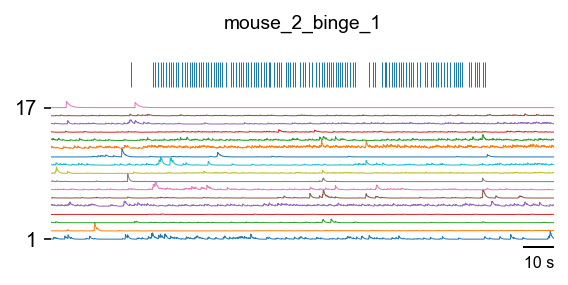

In [125]:
plt.figure(figsize=[4,2])
for order,cell in enumerate(cell_set_2):
    plt.plot(mouse_2_dff_norm[cell]+order+1,lw=0.5)
plt.eventplot(Pump_all_2,lineoffsets=order+5,linewidths=0.5,linelengths=3)
plt.plot([1330,1340],[0,0],color='k',lw=1)
plt.text(x=1335,y=-1,s='10 s',ha='center',va='top')
plt.xlim([mouse_2_dff.index[0],mouse_2_dff.index[-1]])
plt.xlim([1175,1340])
plt.yticks([1,order+1],fontsize=10)
plt.xticks([])
plt.ylim(ymin=-1)
plt.title('mouse_2_binge_1')
sns.despine(bottom=True,left=True)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/mouse_2_binge_1.pdf',dpi=300)
# plt.savefig('/Users/hunglo/Desktop/3rd_supervision/auROC/'+save_file_name+'_auROC_water_negative_neuron.pdf',dpi=300,transparent=True)

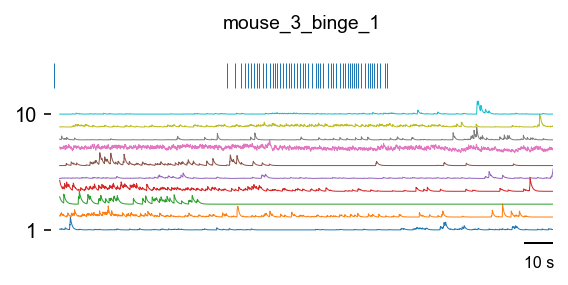

In [182]:
plt.figure(figsize=[4,2])
for order,cell in enumerate(cell_set_3):
    plt.plot(mouse_3_dff_norm[cell]+order+1,lw=0.5)
plt.eventplot(Pump_all_3,lineoffsets=order+4,linewidths=0.5,linelengths=2)
plt.plot([1370,1380],[0,0],color='k',lw=1)
plt.text(x=1375,y=-1,s='10 s',ha='center',va='top')
plt.xlim([mouse_3_dff.index[0],mouse_3_dff.index[-1]])
plt.xlim([1200,1380])
plt.yticks([1,order+1],fontsize=10)
plt.xticks([])
plt.ylim(ymin=-1)
plt.title('mouse_3_binge_1')
sns.despine(bottom=True,left=True)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/mouse_3_binge_1.pdf',dpi=300)

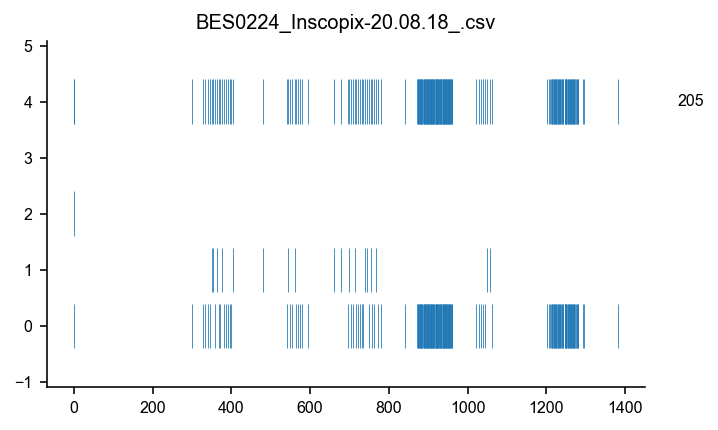

In [44]:
## Load GPIO data with GPIO_event_calculate() function.

## which mouse?

mouse_id = 'BES0224'
# mouse_id = 'BES0225'
# mouse_id = 'BES0233'

# Locate file folder
GPIO_folder = '/Users/hunglo/Desktop/GPIO_phenosys_log_file/'+mouse_id+'/processed/'

extension = 'csv'
os.chdir(GPIO_folder)
result = sorted(glob.glob('*.{}'.format(extension)))
# print(result)

# BES0224: 6
# BES0225: -2
# BES0233: 4

idx = 6
P1, P1C, P2, P2A, Pump_all = GPIO_event_calculate(GPIO_folder+result[idx])

file_date = result[idx].split('-')[-1].split('.')[0] + result[idx].split('-')[-1].split('.')[1] + result[idx].split('-')[-1].split('.')[2][:-1]

plt.figure(figsize=[5,3])
plt.title(result[idx],fontsize=10)
plt.eventplot(Pump_all,lineoffsets = 4,linelengths = 0.8,linewidths=0.4)
plt.eventplot([P1,P1C,P2,P2A],linelengths = 0.8,linewidths=0.4)
plt.text(s=len(Pump_all),x=1600,y=4,va='center',ha='right')
sns.despine()
plt.tight_layout()

In [163]:
## Now try Milk (-) neurons?
## split idx_negative to 3 parts for 3 mice.
idx_negative_mouse_1 = idx_negative[idx_negative<=mouse_1_dff.shape[1]]
idx_negative_mouse_2_temp = idx_negative[idx_negative>mouse_1_dff.shape[1]]
idx_negative_mouse_2 = idx_negative_mouse_2_temp[idx_negative_mouse_2_temp<(mouse_1_dff.shape[1]+mouse_2_dff.shape[1])]
idx_negative_mouse_2 = idx_negative_mouse_2-mouse_1_dff.shape[1]

total_cell_num_neg = len(idx_negative)
used_cell_num_neg = len(idx_negative_mouse_1)+len(idx_negative_mouse_2)
residual_cell_num_neg = total_cell_num_neg-used_cell_num_neg

idx_negative_mouse_3 = idx_negative[-residual_cell_num_neg:] - mouse_1_dff.shape[1] - mouse_2_dff.shape[1]
idx_negative_mouse_3

array([  0,   3,   4,  12,  20,  33,  57,  60,  64,  71,  76,  92,  93,
       105, 126])

In [169]:
## For the first 369 cells from idx_positive, extract those Milk (+) neurons and plot their responses upon binging.
cell_set_1_neg = mouse_1_dff_norm.columns[idx_negative_mouse_1]
cell_set_2_neg = mouse_2_dff_norm.columns[idx_negative_mouse_2]
cell_set_3_neg = mouse_3_dff_norm.columns[idx_negative_mouse_3]

In [167]:
print(len(idx_negative_mouse_1),len(idx_negative_mouse_2),len(idx_negative_mouse_3))

85 41 15


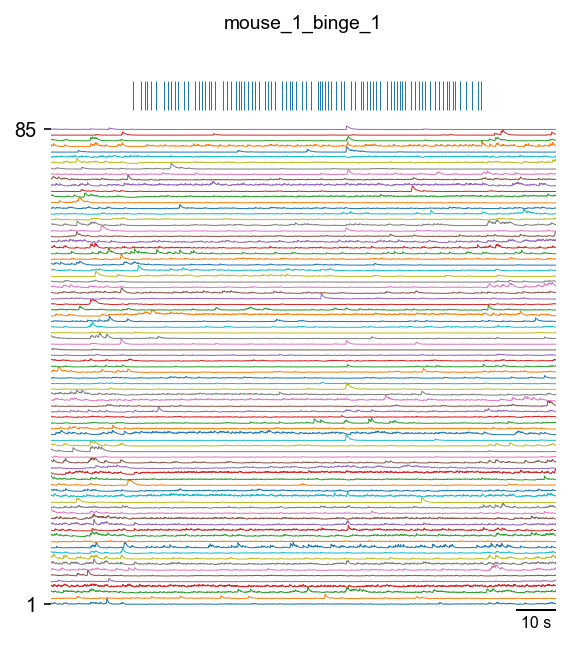

In [183]:
plt.figure(figsize=[4,4.5])
for order,cell in enumerate(cell_set_1_neg):
    plt.plot(mouse_1_dff_norm[cell]+order+1,lw=0.5)
plt.eventplot(Pump_all_1,lineoffsets=order+7,linewidths=0.5,linelengths=5)
plt.plot([970,980],[0,0],color='k',lw=1)
plt.text(x=975,y=-1,s='10 s',ha='center',va='top')
plt.xlim([mouse_1_dff.index[0],mouse_1_dff.index[-1]])
plt.xlim([850,980])
plt.yticks([1,order+1],fontsize=10)
plt.xticks([])
plt.ylim(ymin=-1)
plt.title('mouse_1_binge_1')
sns.despine(bottom=True,left=True)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/milk_neg_mouse_1_binge_1.pdf',dpi=300)

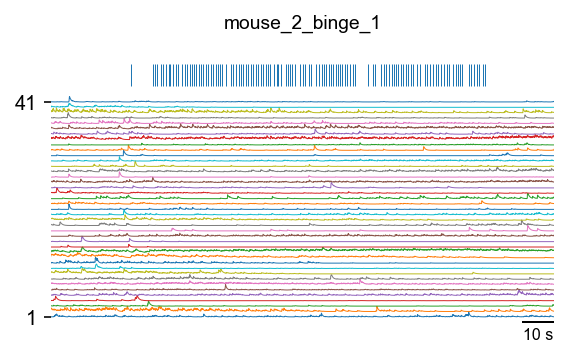

In [178]:
plt.figure(figsize=[4,2.5])
for order,cell in enumerate(cell_set_2_neg):
    plt.plot(mouse_2_dff_norm[cell]+order+1,lw=0.5)
plt.eventplot(Pump_all_2,lineoffsets=order+6,linewidths=0.5,linelengths=4)
plt.plot([1330,1340],[0,0],color='k',lw=1)
plt.text(x=1335,y=-1,s='10 s',ha='center',va='top')
plt.xlim([mouse_2_dff.index[0],mouse_2_dff.index[-1]])
plt.xlim([1175,1340])
plt.yticks([1,order+1],fontsize=10)
plt.xticks([])
plt.ylim(ymin=-1)
plt.title('mouse_2_binge_1')
sns.despine(bottom=True,left=True)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/milk_neg_mouse_2_binge_1.pdf',dpi=300)

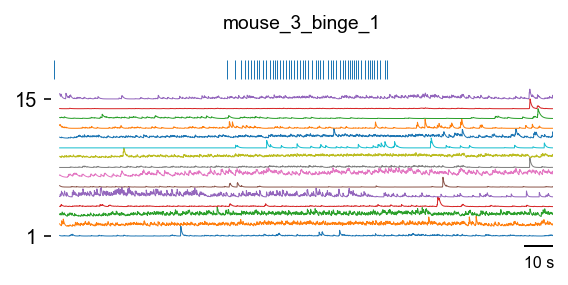

In [181]:
plt.figure(figsize=[4,2])
for order,cell in enumerate(cell_set_3_neg):
    plt.plot(mouse_3_dff_norm[cell]+order+1,lw=0.5)
plt.eventplot(Pump_all_3,lineoffsets=order+4,linewidths=0.5,linelengths=2)
plt.plot([1370,1380],[0,0],color='k',lw=1)
plt.text(x=1375,y=-1,s='10 s',ha='center',va='top')
plt.xlim([mouse_3_dff.index[0],mouse_3_dff.index[-1]])
plt.xlim([1200,1380])
plt.yticks([1,order+1],fontsize=10)
plt.xticks([])
plt.ylim(ymin=-1)
plt.title('mouse_3_binge_1')
sns.despine(bottom=True,left=True)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/milk_neg_mouse_3_binge_1.pdf',dpi=300)

## Milk Neutral cells

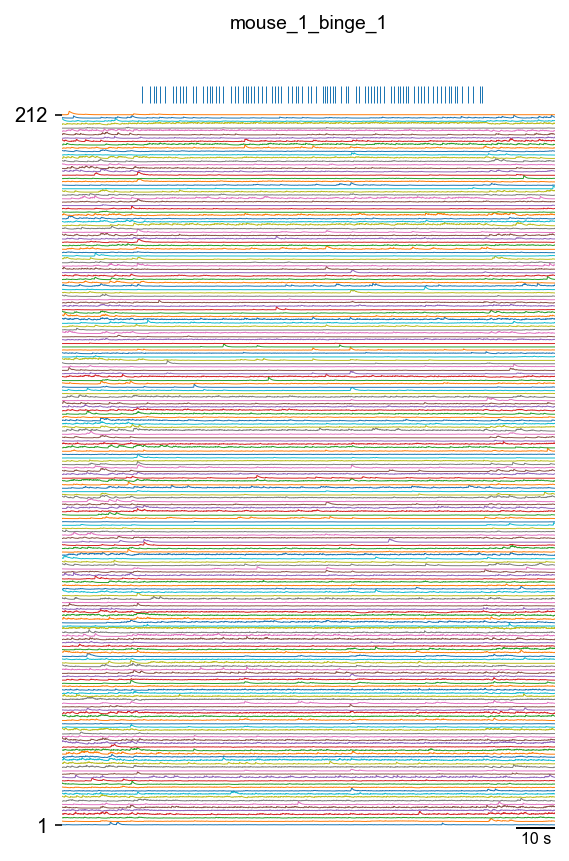

In [226]:
cell_set_1_neg_new =[]
for cell in cell_set_1_neg:
    if cell != ' C109':
        if cell != ' C345':
            cell_set_1_neg_new.append(cell)
cell_set_1_neg_new

idx_neutral_mouse_1_dff_norm = mouse_1_dff_norm.drop(cell_set_1_neg_new,axis=1)
idx_neutral_mouse_1_dff_norm = idx_neutral_mouse_1_dff_norm.drop(cell_set_1,axis=1)
# idx_neutral_mouse_1_dff_norm

plt.figure(figsize=[4,6])
for order,cell in enumerate(idx_neutral_mouse_1_dff_norm.columns):
    plt.plot(idx_neutral_mouse_1_dff_norm[cell]+order+1,lw=0.5)
plt.eventplot(Pump_all_1,lineoffsets=order+7,linewidths=0.5,linelengths=5)
plt.plot([970,980],[0,0],color='k',lw=1)
plt.text(x=975,y=-1,s='10 s',ha='center',va='top')
plt.xlim([mouse_1_dff.index[0],mouse_1_dff.index[-1]])
plt.xlim([850,980])
plt.yticks([1,order+1],fontsize=10)
plt.xticks([])
plt.ylim(ymin=-1)
plt.title('mouse_1_binge_1')
sns.despine(bottom=True,left=True)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/milk_neut_mouse_1_binge_1.pdf',dpi=300)

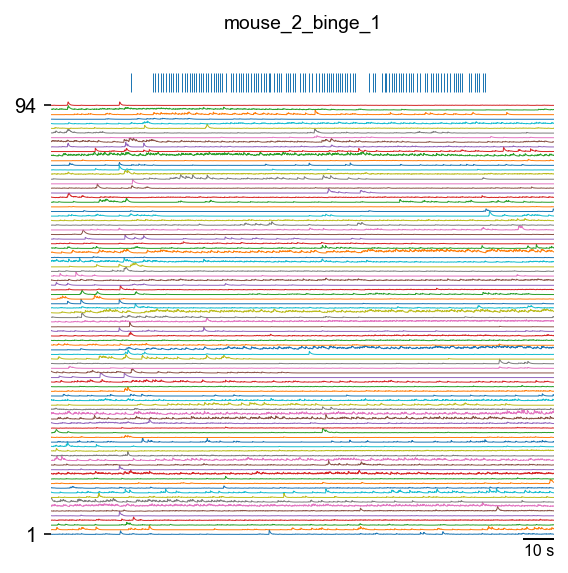

In [230]:
idx_neutral_mouse_2_dff_norm = mouse_2_dff_norm.drop(cell_set_2_neg,axis=1)
idx_neutral_mouse_2_dff_norm = idx_neutral_mouse_2_dff_norm.drop(cell_set_2,axis=1)

plt.figure(figsize=[4,4])
for order,cell in enumerate(idx_neutral_mouse_2_dff_norm.columns):
    plt.plot(idx_neutral_mouse_2_dff_norm[cell]+order+1,lw=0.5)
plt.eventplot(Pump_all_2,lineoffsets=order+6,linewidths=0.5,linelengths=4)
plt.plot([1330,1340],[0,0],color='k',lw=1)
plt.text(x=1335,y=-1,s='10 s',ha='center',va='top')
plt.xlim([mouse_2_dff.index[0],mouse_2_dff.index[-1]])
plt.xlim([1175,1340])
plt.yticks([1,order+1],fontsize=10)
plt.xticks([])
plt.ylim(ymin=-1)
plt.title('mouse_2_binge_1')
sns.despine(bottom=True,left=True)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/milk_neut_mouse_2_binge_1.pdf',dpi=300)

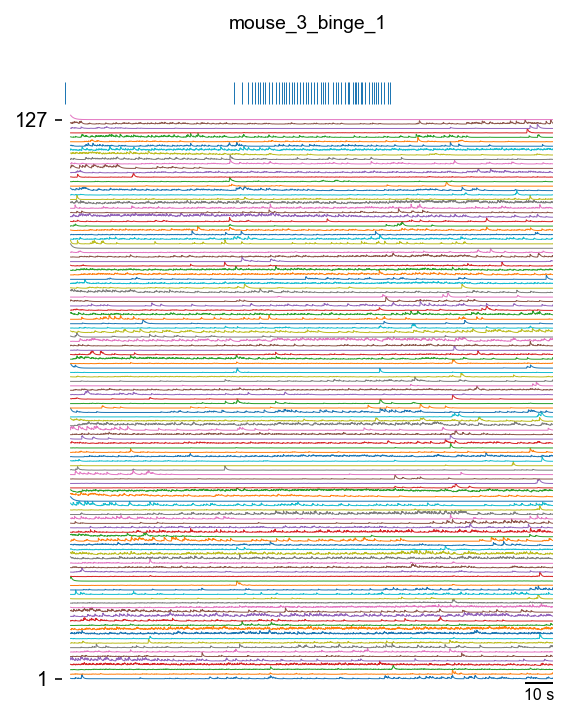

In [234]:
idx_neutral_mouse_3_dff_norm = mouse_3_dff_norm.drop(cell_set_3_neg,axis=1)
idx_neutral_mouse_3_dff_norm = idx_neutral_mouse_3_dff_norm.drop(cell_set_3,axis=1)

plt.figure(figsize=[4,5])
for order,cell in enumerate(idx_neutral_mouse_3_dff_norm.columns):
    plt.plot(idx_neutral_mouse_3_dff_norm[cell]+order+1,lw=0.5)
plt.eventplot(Pump_all_3,lineoffsets=order+7,linewidths=0.5,linelengths=5)
plt.plot([1370,1380],[0,0],color='k',lw=1)
plt.text(x=1375,y=-1,s='10 s',ha='center',va='top')
plt.xlim([mouse_3_dff.index[0],mouse_3_dff.index[-1]])
plt.xlim([1200,1380])
plt.yticks([1,order+1],fontsize=10)
plt.xticks([])
plt.ylim(ymin=-1)
plt.title('mouse_3_binge_1')
sns.despine(bottom=True,left=True)
plt.tight_layout()
plt.savefig('/Users/hunglo/Desktop/3rd_supervision/DFF_processed/milk_neut_mouse_3_binge_1.pdf',dpi=300)